# Pytorch Lightning Tutorial with MNIST

This notebook is the [starter tutorial from the official documentation](https://lightning.ai/docs/pytorch/stable/starter/introduction.html), with some added features. In the notebook, an Autoencoder is implemented for the MNIST dataset.

Pytorch Lightning uses Pytorch under the hood; however, the usual Pytorch boilerplate code is abstracted to a cleaner implementation similar to Keras. In that implementation, the code is structured in two major classes:

- `LightningModule`: this class takes the Pytorch model and expects the definition of some functions, such as:
  - `training_step()`
  - `validation_step()`
  - `test_step()`
  - `configure_optimizers()`, which returns the optimizer and the scheduler
  - `forward()`
  - `predict_step()`
- `Trainer`: this class takes the `LightningModule` and the datasets in the form of `Dataloaders` and is able to run these methods:
  - `fit()`
  - `test()`
  - `predict()`

In addition to those classes, we also need Pytorch `Dataloaders`.

Many nice operations are automatically performed via arguments/flags in the `Trainer` and minor definitions/calls in `LightningModule`:

- Epoch and batch iteration
- `optimizer.step()`, `loss.backward()`, `optimizer.zero_grad()` calls
- Calling of `model.eval()`, enabling/disabling grads during evaluation
- [Checkpoint Saving and Loading](https://lightning.ai/docs/pytorch/stable/common/checkpointing.html)
- Tensorboard logging (see [loggers](https://lightning.ai/docs/pytorch/stable/visualize/loggers.html) options)
- [Multi-GPU](https://lightning.ai/docs/pytorch/stable/accelerators/gpu.html) support
- etc.

Alltogether, this is a summary of the contents implemented in the notebook:

- The encoder/decoder models are created with Pytorch.
- A Lightning model is created with `LightningModule`; it has the most common methods:
  - `training_step()` with loss computation and logging
  - `validation_step()`
  - `test_step()`
  - `configure_optimizers()`, which returns the optimizer and the scheduler
  - `forward()`, if the model is called
  - `predict_step()` for using it in `Trainer().predict()`
- A `Trainer` is instantiated and `fit()` with:
  - `EarlyStopping` passed as a callbac
  - Train and validation data loaders
- The model is tested with `Trainer().test()`
- The checkpoint is loaded and used:
  - The Pytorch model is used independently from Lightning
  - The `Trainer().predict()` interface is used to predict a dataset
- Training is resumed starting with a desired framework.
- Logs are visualized with Tensorboard
- Interesting `Trainer` tricks are shown
  - Learning rate finding
  - Accumulated gradient batching
  - Mixed precision
  - Gradient clipping

Interesting resources:

- [Lightning in 15 Minutes](https://lightning.ai/docs/pytorch/stable/starter/introduction.html)
- [How to Organize PyTorch Into Lightning](https://lightning.ai/docs/pytorch/stable/starter/converting.html)

Installation of the environment and **Lightning**:

```bash
# Install/activate a basic environment
conda env create -f conda.yaml
conda activate ds
# Alternatively, if you have an env and wnat to install tensorboard
python -m pip install lightning

# OPTIONAL: Pytorch on Windows + CUDA 11.7
# Update your NVIDIA drivers: https://www.nvidia.com/Download/index.aspx
# I have version 12.1, but it works with older versions, e.g. 11.7
# Check your CUDA version with: nvidia-smi.exe
# In case of any runtime errors, check vrsion compatibility tables:
# https://github.com/pytorch/vision#installation
python -m pip install -U torch==1.13+cu117 torchvision==0.14+cu117 torchaudio torchtext==0.14 --index-url https://download.pytorch.org/whl/cu117
```

## 0. GPU Setup

In [1]:
import os
import torch
import torchvision

print(torch.__version__)
# '1.13.0+cu117'

1.13.0+cu117


In [2]:
# Get info of all GPU devices
!nvidia-smi

Fri Aug 11 19:06:26 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:22:00.0 Off |                  N/A |
|  0%   38C    P8              14W / 170W |      0MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Set environment variable with possible device ids
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
print(os.environ["CUDA_VISIBLE_DEVICES"])
# Set device: 0 or 1
# NOTE: indices are not necessarily the ones shown by nvidia-smi
# We need to try them with the cell below
torch.cuda.set_device("cuda:0")

0,1


In [4]:
# Check that the selected device is the desired one
print("Torch version?", torch.__version__)
print("Torchvision version?", torchvision.__version__)
print("Is cuda available?", torch.cuda.is_available())
print("Is cuDNN version:", torch.backends.cudnn.version())
print("cuDNN enabled? ", torch.backends.cudnn.enabled)
print("Device count?", torch.cuda.device_count())
print("Current device?", torch.cuda.current_device())
print("Device name? ", torch.cuda.get_device_name(torch.cuda.current_device()))

Torch version? 1.13.0+cu117
Torchvision version? 0.14.0+cu117
Is cuda available? True
Is cuDNN version: 8500
cuDNN enabled?  True
Device count? 1
Current device? 0
Device name?  NVIDIA GeForce RTX 3060


## 1. Define the Lightning Model

A LightningModule enables your PyTorch nn.Module to play together in complex ways inside the training_step (there is also an optional validation_step and test_step).

In [5]:
import os
from torch import optim, nn, utils, Tensor
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import lightning.pytorch as pl

# ensure reproducibility
pl.seed_everything(42, workers=True)

# define any number of nn.Modules (or use your current ones)
# actually, we can define the model outside and then pass
# it to the LightningModule
# we can also do it with 1-liners
# encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))
# decoder = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))
        
    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))
        
    def forward(self, x):
        return self.decoder(x)

# Optional class, not used
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = x.view(x.size(0), -1) # in this case, the batch is reshaped to (B, 28*28)
        return self.decoder(self.encoder(x))    

# define the LightningModule
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, encoder, decoder, learning_rate=0.001, batch_size=64):
        super().__init__()
        # the model can be defined here or outside
        self.encoder = encoder
        self.decoder = decoder
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        # OPTIONAL: automatically save all the hyperparameters passed to init,
        # but exclude things we don't want to save
        # NOTE: hyperparams saved to lightning_logs/version_X/hparams.yaml
        self.save_hyperparameters("learning_rate", "batch_size", ignore=["encoder", "decoder"])
        # then, hyperparams are also available as
        # self.hparams.learning_rate

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop
        # it is independent of forward()
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z) # x_hat is (B, 28*28)
        loss = F.mse_loss(x_hat, x)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss.item()) # important to take .item() to remove computational graph
        # If we have a scheduler:
        # lr = self.optimizers().param_groups[0]['lr']
        # self.log('learning_rate', lr)
        return loss

    def validation_step(self, batch, batch_idx):
        # this is the validation loop (optional)
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        val_loss = F.mse_loss(x_hat, x)
        self.log("val_loss", val_loss.item())
        # we would return the loss if sth needs to be done on
        # hooks like on_validation_end()

    def test_step(self, batch, batch_idx):
        # this is the test loop (optional)
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = F.mse_loss(x_hat, x)
        self.log("test_loss", test_loss.item())
        # we would return the loss if sth needs to be done on
        # hooks like on_test_end()

    def configure_optimizers(self):
        # intantiate return optimizer and learning rate schedulers
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=70, gamma=0.1)
        return [optimizer], [lr_scheduler]
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # in this case, the batch is reshaped to (B, 28*28)
        return self.decoder(self.encoder(x))
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        # this calls forward
        # this will be used in trainer.predict(...)
        # we can make this step more sophisticated, if desired
        # NOTE: we can also avoid the forward() call
        # and implement any desired predict step here!
        return self(batch[0]) # a batch is a list with one batch inside, so we take element 0


# init the autoencoder
encoder = Encoder() # nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))
decoder = Decoder() # nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))
autoencoder = LitAutoEncoder(encoder, decoder)

c:\Users\Msagardi\AppData\Local\anaconda3\envs\ds\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Global seed set to 42


## 2. Define a Dataset

Lightning supports ANY iterable (DataLoader, numpy, etc…) for the train/val/test/predict splits.

In [6]:
# setup data
train_set = MNIST(os.path.join(os.getcwd(), "data"), download=True, transform=ToTensor())
test_set = MNIST(os.path.join(os.getcwd(), "data"), download=True, train=False, transform=ToTensor())
# use 20% of training data for validation
train_set_size = int(len(train_set) * 0.8)
valid_set_size = len(train_set) - train_set_size
# split the train set into two
seed = torch.Generator().manual_seed(42)
train_set, valid_set = utils.data.random_split(train_set, [train_set_size, valid_set_size], generator=seed)

# loaders
# we can/should define batch_size as a hyperparameter in the LightningModule to be able to tune it
# but the trainer.text() which uses the test_loader does not use the hyperparameter
# HOWEVER, the recommended way is to tune/find the batch size and then instantiate the loaders with a hard-coded value
train_loader = utils.data.DataLoader(train_set) # , batch_size=64)
valid_loader = utils.data.DataLoader(valid_set) #, batch_size=64)
test_loader = utils.data.DataLoader(test_set, batch_size=64)

## 3. Train the Model

The Lightning [Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html) “mixes” any [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) with any dataset and abstracts away all the engineering complexity needed for scale.

The Lightning [Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html) automates [40+ tricks](https://lightning.ai/docs/pytorch/stable/common/trainer.html#trainer-flags) including:

- Epoch and batch iteration
- `optimizer.step()`, `loss.backward()`, `optimizer.zero_grad()` calls
- Calling of `model.eval()`, enabling/disabling grads during evaluation
- [Checkpoint Saving and Loading](https://lightning.ai/docs/pytorch/stable/common/checkpointing.html)
- Tensorboard logging (see [loggers](https://lightning.ai/docs/pytorch/stable/visualize/loggers.html) options)
- [Multi-GPU](https://lightning.ai/docs/pytorch/stable/accelerators/gpu.html) support
- [TPU](https://lightning.ai/docs/pytorch/stable/accelerators/tpu.html)
- [16-bit precision](https://lightning.ai/docs/pytorch/stable/advanced/speed.html#speed-amp) AMP support

One of the most important functionalities to improve our training is [early stopping](https://lightning.ai/docs/pytorch/stable/common/early_stopping.html), which is implemented with callbacks.

In [9]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

early_stop_callback = EarlyStopping(
    monitor="val_loss", # must be saved with self.log() in the LightningModule
    min_delta=0.00, # minimum change in the monitored quantity to qualify as an improvement
    patience=3,
    verbose=False,
    mode="min" # or max if val_accuracy
)

Additionally, we can also use the `ModelCheckpoint` callback to save both the last and the best model in our specified folder:

In [10]:
from lightning.pytorch.callbacks import ModelCheckpoint

# NOTE: if no ModelCheckpoint is specified, after each epoch the model checkpoint
# is saved in ./lightning_logs/version_X/checkpoints
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss', # which metric to monitor
    dirpath='./output_mnist',  # specify the path to save the checkpoints
    filename='best',  # best.ckpt - we can also use naming formats: {epoch}-{val_loss:.2f}
    save_last=True,  # ensures that the last epoch's model is saved: last.ckpt
    mode='min',  # save the model with the minimum 'val_loss'
)

Finally, note that logs will be automatically written to `./lightning_logs` using Tensorboard (default); if we want to control logging, we can do it as follows:

```python
from lightning.pytorch.loggers import TensorBoardLogger # other loggers are also available!

# Create the logger
logger = TensorBoardLogger(
    save_dir="logs/", # folder
    name="my_experiment",
    version="1" # if no version passed, it will be automatically incremented
)

# Pass the logger to the Trainer
trainer = Trainer(logger=logger)
```

In [11]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
# if GPU is available, we can invoke it with the accelerator flag
# the checkpoint and the logs are saved to lightining_logs/version_X
trainer = pl.Trainer(
    # OPTIONAL arguments
    limit_train_batches=100,
    limit_val_batches=100,
    limit_test_batches=100,
    max_epochs=1,
    accelerator="gpu", # "mps" for Apple Silicon! Metal Performance Shaders
    devices=1, # in case we have several GPUs
    callbacks=[early_stop_callback, checkpoint_callback]
    # if we want to disable saving / checkpointing
    # enable_checkpointing=False
    # if we want to control the directory where the checkpoint is saved
    # default_root_dir="some/path/"
)
trainer.fit(
    model=autoencoder,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader
    # if we want to resume training where we left
    # ckpt_path="some/path/to/my_checkpoint.ckpt"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 50.4 K
1 | decoder | Decoder | 51.2 K
------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\Msagardi\AppData\Local\anaconda3\envs\ds\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\Msagardi\AppData\Local\anaconda3\envs\ds\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## 4. Test the Model

In [12]:
# test the model
# WARNING: We should first load the best model and then run .test(),
# see below how to load the best model
trainer.test(model=autoencoder,
             dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
c:\Users\Msagardi\AppData\Local\anaconda3\envs\ds\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.06443773210048676    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.06443773210048676}]

## 5. Load Checkpoint and Use the Model

Once we’ve trained the model you can export to onnx, torchscript and put it into production or simply load the weights and run predictions.

In [13]:
# load checkpoint as Lightning object
# check logs path for correct version_X and checkpoint
#checkpoint = "./lightning_logs/version_19/checkpoints/epoch=0-step=100.ckpt"
checkpoint = "./output_mnist/best.ckpt"
lit_autoencoder = LitAutoEncoder.load_from_checkpoint(checkpoint, encoder=Encoder(), decoder=Decoder())

# We should run trainer.test() now

# we can also load the checkpoint with torch
# many things are saved: 'state_dict', 'optimizer_states', 'hyper_parameters', etc.
checkpoint_torch = torch.load(checkpoint, map_location=lambda storage, loc: storage)
print(checkpoint_torch.keys())
print(checkpoint_torch["hyper_parameters"])

# choose your trained nn.Module
# having the model defined outside makes it easier to use it later
encoder = lit_autoencoder.encoder
encoder.eval()

# embed 4 fake images!
fake_image_batch = torch.rand(4, 28 * 28, device=lit_autoencoder.device)
embeddings = encoder(fake_image_batch)
print("⚡" * 20, "\nPredictions (4 image embeddings):\n", embeddings, "\n", "⚡" * 20)

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])
{'learning_rate': 0.001, 'batch_size': 64}
⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ 
Predictions (4 image embeddings):
 tensor([[-0.8746, -0.5090, -0.5199],
        [-0.8949, -0.4956, -0.5267],
        [-0.8948, -0.3335, -0.4570],
        [-0.8834, -0.5024, -0.5150]], device='cuda:0',
       grad_fn=<AddmmBackward0>) 
 ⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡


In [14]:
# Also, it is possible to use the forward() and the predict_step() functions
# of the LitAutoencoder from the Trainer
# NOTE that predict_step() is called
trainer = pl.Trainer()
predictions = trainer.predict(model=lit_autoencoder, dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
c:\Users\Msagardi\AppData\Local\anaconda3\envs\ds\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [15]:
# Number of batches
len(predictions)

157

In [16]:
# Batch 0, all outputs from Autoencoder: (B, 28*28)
# NOTE that in this implementation the images were not resized to 28x28
predictions[0].shape

torch.Size([64, 784])

## 6. Visualize Logs

In [17]:
# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs
# http://localhost:6006/

### Optional: Extract Tensorboard Logs

In [17]:
from tensorboard.backend.event_processing import event_accumulator

# Path to the TensorBoard log directory
# NOTE that we check in the folder structure the metric we want...
#log_dir = "./runs/fashion_mnist_experiment_1/"
log_dir = './lightning_logs/version_44'
#log_dir = './runs/fashion_mnist_experiment_1/Training vs. Validation Loss_Validation/'

# Load the TensorBoard event files
event_acc = event_accumulator.EventAccumulator(log_dir)
event_acc.Reload()

# Print the list of events
print("Event Keys:", event_acc.Tags())

# Print the list of scalar tags
print("Scalar Tags:", event_acc.scalars.Keys()) # This output should be used

Event Keys: {'images': [], 'audio': [], 'histograms': [], 'scalars': ['hp_metric', 'train_loss', 'epoch', 'val_loss', 'test_loss'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
Scalar Tags: ['hp_metric', 'train_loss', 'epoch', 'val_loss', 'test_loss']


In [18]:
# Get the scalar events (train and validation losses)
metric = event_acc.Scalars('train_loss')

# Extract the loss values as Python lists
metric_values = [event.value for event in metric]

# Print the extracted loss values
print("Metric Values:", metric_values)

Metric Values: [0.08668341487646103, 0.05452636629343033]


## 7. Re-Train or Resume Training

In [20]:
#encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))
#decoder = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))
encoder = Encoder()
decoder = Decoder()
autoencoder = LitAutoEncoder(encoder, decoder)

trainer = pl.Trainer(
    limit_train_batches=100,
    limit_val_batches=100,
    limit_test_batches=100,
    max_epochs=1,
    accelerator="gpu"
)

# automatically restores model, epoch, step, LR schedulers, etc...
trainer.fit(
    model=autoencoder,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
    #ckpt_path="./lightning_logs/version_44/checkpoints/epoch=0-step=100.ckpt"
    ckpt_path="./output_mnist/best.ckpt"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at ./output_mnist/best.ckpt
c:\Users\Msagardi\AppData\Local\anaconda3\envs\ds\lib\site-packages\lightning\pytorch\trainer\call.py:247: UserWarning: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': 'val_loss', 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None}", "EarlyStopping{'monitor': 'val_loss', 'mode': 'min'}"].
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 50.4 K
1 | decoder | Decoder | 51.2 K
------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Tota

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\Msagardi\AppData\Local\anaconda3\envs\ds\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\Msagardi\AppData\Local\anaconda3\envs\ds\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1` reached.


## 8. Trainer Tricks

Sources:

- [Training Tricks](https://lightning.ai/docs/pytorch/stable/advanced/training_tricks.html)
- [Trainer Flags](https://lightning.ai/docs/pytorch/stable/common/trainer.html)
- [Trainer API](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.trainer.trainer.Trainer.html#lightning.pytorch.trainer.trainer.Trainer)

In [23]:
encoder = Encoder()
decoder = Decoder()
model = LitAutoEncoder(encoder, decoder)

### Automatic Batch Size Finder

:warning: **Warning: This did not work.**

```python
from lightning.pytorch.tuner import Tuner

# Usually we know the possible batch size, but we can find it, too
# Usually we want to have the largest batch size possible
# For this to work, we need in the LightningModule, either
# self.batch_size
# self.hparams.batch_size
# HOWEVER, the recommended way is to tune/find the batch size and then instantiate the loaders with a hard-coded value

# Create a tuner for the trainer
trainer = pl.Trainer()
tuner = Tuner(trainer)

# Auto-scale batch size by growing it exponentially (default)
tuner.scale_batch_size(model, train_dataloaders=train_loader, val_dataloaders=valid_loader, mode="power")

# Auto-scale batch size with binary search
tuner.scale_batch_size(model, train_dataloaders=train_loader, val_dataloaders=valid_loader, mode="binsearch")

# THEN:
# Fit as normal with new batch size
# trainer.fit(model)
```

### Automatic Learning Rate Finder

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 1.0964781961431852e-07
Restoring states from the checkpoint path at c:\Users\Msagardi\git_repositories\tool_guides\pytorch_lightning\.lr_find_b540e2bc-58f4-44c6-96c3-324f5751bb4f.ckpt
Restored all states from the checkpoint at c:\Users\Msagardi\git_repositories\tool_guides\pytorch_lightning\.lr_find_b540e2bc-58f4-44c6-96c3-324f5751bb4f.ckpt
C:\Users\Msagardi\AppData\Local\Temp\ipykernel_78204\3095258436.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'lr': [1e-08, 1.4454397707459274e-08, 1.7378008287493753e-08, 2.0892961308540398e-08, 2.51188643150958e-08, 3.019951720402016e-08, 3.630780547701014e-08, 4.36515832240166e-08, 5.248074602497726e-08, 6.309573444801934e-08, 7.585775750291837e-08, 9.120108393559096e-08, 1.0964781961431852e-07, 1.3182567385564074e-07, 1.5848931924611133e-07, 1.9054607179632475e-07, 2.2908676527677735e-07, 2.7542287033381663e-07, 3.311311214825911e-07, 3.9810717055349735e-07, 4.786300923226383e-07, 5.75439937337157e-07, 6.918309709189366e-07, 8.317637711026709e-07, 1e-06, 1.2022644346174132e-06, 1.445439770745928e-06, 1.7378008287493761e-06, 2.089296130854039e-06, 2.5118864315095797e-06, 3.0199517204020163e-06, 3.630780547701014e-06, 4.365158322401661e-06, 5.248074602497728e-06, 6.3095734448019305e-06, 7.585775750291836e-06, 9.120108393559096e-06, 1.0964781961431852e-05, 1.3182567385564076e-05, 1.584893192461114e-05, 1.9054607179632464e-05, 2.2908676527677725e-05, 2.7542287033381663e-05, 3.311311214825911e

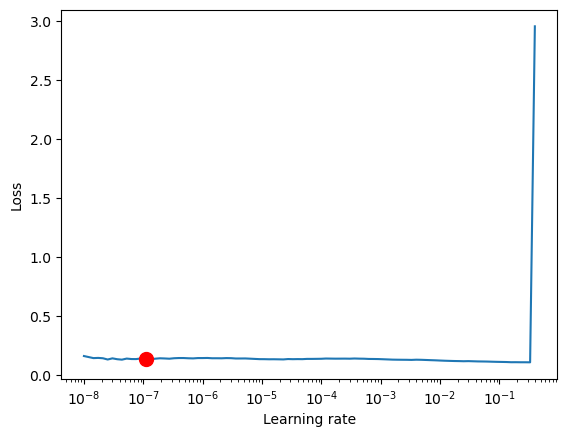

In [38]:
# Instantiate Trainer and Tuner
trainer = pl.Trainer()
tuner = Tuner(trainer)

# Run learning rate finder
# https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.tuner.tuning.Tuner.html#lightning.pytorch.tuner.tuning.Tuner
lr_finder = tuner.lr_find(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

# Results can be found in
print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
model.learning_rate = new_lr
model.hparams.learning_rate = new_lr

# THEN:
# Fit model
# trainer.fit(model)

### Gradient Clipping to Avoid Exploding/Vanishing Gradients

```python
# DEFAULT (ie: don't clip)
trainer = Trainer(gradient_clip_val=0)

# clip gradients' global norm to <=0.5 using gradient_clip_algorithm='norm' by default
trainer = Trainer(gradient_clip_val=0.5)

# clip gradients' maximum magnitude to <=0.5
trainer = Trainer(gradient_clip_val=0.5, gradient_clip_algorithm="value")
```

### Accummulate Gradient Batches

```python
# accumulate every 4 batches (effective batch size is batch*4)
trainer = Trainer(accumulate_grad_batches=4)
```

### Precision

> Lightning supports either double (64, default), float (32), bfloat16 (bf16), or half (16) precision training.
> Half precision, or mixed precision, is the combined use of 32 and 16 bit floating points to reduce memory footprint during model training.
> This can result in improved performance, achieving +3X speedups on modern GPUs.

```python
# default used by the Trainer
trainer = Trainer(precision=32)

# 16-bit precision
trainer = Trainer(precision="16-mixed", accelerator="gpu", devices=1)  # works only on CUDA

# bfloat16 precision
trainer = Trainer(precision="bf16-mixed")

# 64-bit precision
trainer = Trainer(precision=64)
```

### Some Other Flags

```python
# Profiler: get time spent in each function call
trainer = Trainer(profiler=True)

# Number of epochs
trainer = Trainer(max_epochs=100)

# Limit number of batches (for testing); also: limit_val_batches, limit_test_batches
trainer = Trainer(limit_train_batches=100)

# Logging; default is 50
trainer = Trainer(log_every_n_steps=50)

# Use deterministic algos, but slower; defaults to False
trainer = Trainer(deterministic=True)

# Faster on GPUs if sizes don't change
trainer = Trainer(benchmark=True)

# The trainer has also properties!
trainer.current_epoch
trainer.logged_metrics
trainer.num_training_batches
trainer.train_dataloader
trainer.logger
#...
```

## 9. Interesting Links

- Log histograms of weights: [Track and Visualize Experiments](https://lightning.ai/docs/pytorch/stable/visualize/logging_intermediate.html)
- Save checkpoints by condition: [Customize checkpointing behavior](https://lightning.ai/docs/pytorch/stable/common/checkpointing_intermediate.html)
- [Debugging](https://lightning.ai/docs/pytorch/stable/debug/debugging_basic.html)
- [Profiling](https://lightning.ai/docs/pytorch/stable/tuning/profiler_basic.html)
- [Deploy models into production with ONNX](https://lightning.ai/docs/pytorch/stable/deploy/production_advanced.html)
- [Customize the Trainer with Callbacks](https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html)
- [Effective Training Tricks](https://lightning.ai/docs/pytorch/stable/advanced/training_tricks.html)
  - Accumulate gradient batches
  - Gradient clipping
  - Stochastic Weight Averaging
  - Batch Size Finder
  - Learning Rate Finder
  - N-Bit precision
    - [Basic](https://lightning.ai/docs/pytorch/stable/common/precision_basic.html)
    - [Intermediate](https://lightning.ai/docs/pytorch/stable/common/precision_intermediate.html)